# Аналитика маркетинговых затрат Яндекс.Афиши

Необходимо оптимизировать маркетинговые затраты Яндекс.Афиши. В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года. В рамках проекта необходимо изучить особенности поведения пользователей, сколько денег приносит каждый клиент и в какой момент расходы на клиента окупаются

### План работ
1. Прочитать данные и информацию о них
2. Провести предобработку данных (избавиться от пропусков, изменить типы данных)
3. Построить отчёты и посчитать метрики
5. Сделать итоговый вывод: порекомендовать маркетологам, куда и сколько им стоит вкладывать денег

### Описание данных:

Таблица visits (лог сервера с информацией о посещениях сайта):
- *Uid* — уникальный идентификатор пользователя
- *Device* — категория устройства пользователя
- *Start Ts* — дата и время начала сессии
- *End Ts* — дата и время окончания сессии
- *Source Id* — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- *Uid* — уникальный id пользователя, который сделал заказ
- *Buy Ts* — дата и время заказа
- *Revenue* — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- *source_id* — идентификатор рекламного источника
- *dt* — дата
- *costs* — затраты на этот рекламный источник в этот день

### Шаг 1. Откроем файл с данными и изучим общую информацию

In [65]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [67]:
orders = pd.read_csv ('/datasets/orders_log.csv')
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [68]:
costs = pd.read_csv ('/datasets/costs.csv')
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


### Вывод

С помощью метода .info() и предварительной визуальной оценки данных можно сделать вывод, что необходимо:
1. заменить названия столбцов в датафрэйме
2. исправить тип данных в переменных с датой

### Шаг 2. Подготовим данные

In [69]:
#заменим названия столбцов (приведем к нижнему регистру и уберем пробелы)
#visits.rename(columns={'Device': 'device', 'End Ts': 'end_ts', 'Source Id': 'source_id', 'Start Ts': 'start_ts', 'Uid': 'uid'}, inplace=True)
#orders.rename(columns={'Buy Ts': 'buy_ts', 'Revenue': 'revenue', 'Uid': 'uid'}, inplace=True)

visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values] 

In [70]:
#заменим тип на datetime64 для дальнейшей работы с датой
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d %H:%M:%S')

### Вывод

Для дальнейшего анализа были:

1. изменены наименования столбцов
2. исправлены типы данных с объектного на дату

### Шаг 3. Посчитаем метрики

In [71]:
#определим, сколько людей пользуются в день, неделю, месяц
#добавим столбцы, в которые выделим неделю, месяц, год и дату
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
#рассчитаем среднее количество уникальных пользователей в день, неделю и месяц
dau_total = visits.groupby('date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()

print('Среднее количество пользователей в день:',int(dau_total))
print('Среднее количество пользователей в неделю:',int(wau_total))
print('Среднее количество пользователей в месяц:',int(mau_total))

Среднее количество пользователей в день: 907
Среднее количество пользователей в неделю: 5716
Среднее количество пользователей в месяц: 23228


In [72]:
#оценим регулярность использования продукта
sticky_wau = (dau_total / wau_total *100).round(2)
print('% от всех пользователей за неделю ежедневно посещают сайт')
print(sticky_wau)
print()
sticky_mau = (dau_total / mau_total *100).round(2)
print('% от всех пользователей за месяц ежедневно посещают сайт')
print(sticky_mau)

% от всех пользователей за неделю ежедневно посещают сайт
uid    15.88
dtype: float64

% от всех пользователей за месяц ежедневно посещают сайт
uid    3.91
dtype: float64


 Показатель                          | Touch   | Desktop 
------------------------------------------------------
Среднее количество пользователей в день   |   252   |    659    
Среднее количество пользователей в неделю |  1634   |   4129    
Среднее количество пользователей в месяц  |  6825   |   16724   


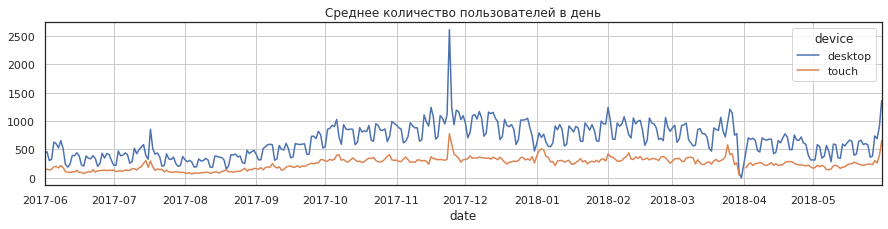

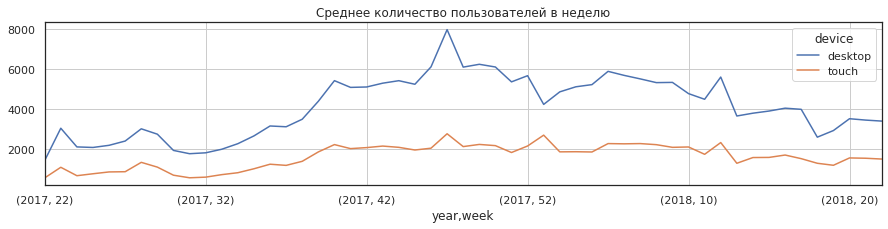

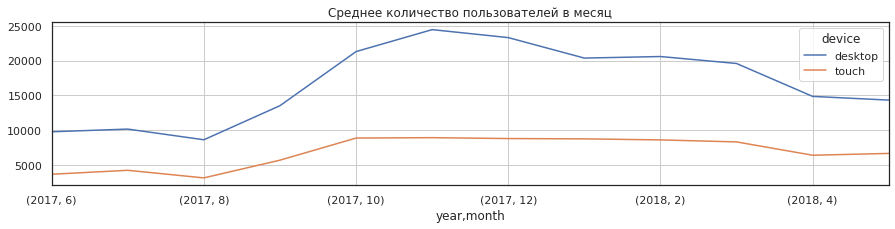

In [73]:
#определим, сколько людей пользуются в день, неделю, месяц по категории устройства
#построим таблицу со средними значениями метрик по девайсам
print(' Показатель                          | Touch   | Desktop ')
print('------------------------------------------------------')
print('{: ^30} | {: ^7} | {: ^9} '.format("Среднее количество пользователей в день  ", int(np.mean(visits[visits['device'] == 'touch'].groupby('date').agg({'uid': 'nunique'}))), int(np.mean(visits[visits['device'] == 'desktop'].groupby('date').agg({'uid': 'nunique'})))))
print('{: ^30} | {: ^7} | {: ^9} '.format("Среднее количество пользователей в неделю", int(np.mean(visits[visits['device'] == 'touch'].groupby(['year', 'week']).agg({'uid': 'nunique'}))), int(np.mean(visits[visits['device'] == 'desktop'].groupby(['year', 'week']).agg({'uid': 'nunique'})))))
print('{: ^30} | {: ^7} | {: ^9} '.format("Среднее количество пользователей в месяц ", int(np.mean(visits[visits['device'] == 'touch'].groupby(['year', 'month']).agg({'uid': 'nunique'}))), int(np.mean(visits[visits['device'] == 'desktop'].groupby(['year', 'month']).agg({'uid': 'nunique'})))))

#построим графики
fig, ax = plt.subplots(figsize = (15,3))
device = ['touch', 'desktop']
pd.pivot_table(visits.query('device.isin(@device)'),
               index = 'date',
               columns = 'device',
               values = 'uid',
               aggfunc = 'nunique').plot(grid=True, ax = ax, title='Среднее количество пользователей в день')
plt.show()
fig, ax = plt.subplots(figsize = (15,3))
pd.pivot_table(visits.query('device.isin(@device)'),
               index = ['year', 'week'],
               columns = 'device',
               values = 'uid',
               aggfunc = 'nunique').plot(grid=True, ax = ax, title='Среднее количество пользователей в неделю')
plt.show()
fig, ax = plt.subplots(figsize = (15,3))
pd.pivot_table(visits.query('device.isin(@device)'),
               index = ['year', 'month'],
               columns = 'device',
               values = 'uid',
               aggfunc = 'nunique').plot(grid=True, ax = ax, title='Среднее количество пользователей в месяц')

In [74]:
#найдем количество сессий в день на одного пользователя
#найдем количество сессий и пользователей с группировкой по месяцу и году
sessions_per_user = visits.groupby(['year', 'month']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
#разделим число сессий на количество пользователей за месяц
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print(sessions_per_user)

            n_sessions  n_users  sessions_per_user
year month                                        
2017 6           16505    13259           1.244815
     7           17828    14183           1.256998
     8           14355    11631           1.234202
     9           23907    18975           1.259921
     10          37903    29692           1.276539
     11          43969    32797           1.340641
     12          41983    31557           1.330386
2018 1           36939    28716           1.286356
     2           37182    28749           1.293332
     3           35679    27473           1.298693
     4           26515    21008           1.262138
     5           26635    20701           1.286653


In [75]:
#найдем прдолжительность сессии
#добавим столбец с продолжительностью сессии в секундах
visits['duration_ts_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
#оценим распределение -> распределение не нормальное -> оценим среднее с помощью моды
duration_ts_sec_avg = visits['duration_ts_sec'].mode()
print('Средняя продолжительность сессии, сек')
print(duration_ts_sec_avg)

Средняя продолжительность сессии, сек
0    60
dtype: int64


In [76]:
#оценим, как часто люди возвращаются, рассчитаем Retention Rate
#найдем дату первой сессии, данные запишем в объект Series, который объединим с исходным по uid пользователя
first_session_date = visits.groupby(['uid']).agg({'start_ts':'min'}).rename(columns = {'start_ts':'start_ts_min'})
visits_new = visits.set_index('uid').join(first_session_date).reset_index()

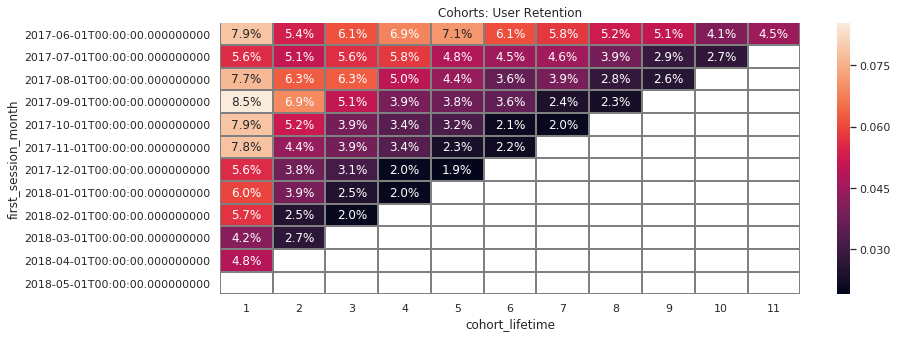

In [77]:
#найдем месяц сессии и первой сессии
visits_new['session_month'] = visits_new['start_ts'].astype('datetime64[M]')
visits_new['first_session_month'] = visits_new['start_ts_min'].astype('datetime64[M]')
#для каждой строки рассчитаем lifetime пользователя в рамках когорты
visits_new['cohort_lifetime'] = visits_new['session_month'] - visits_new['first_session_month']
visits_new['cohort_lifetime'] = visits_new['cohort_lifetime'] / np.timedelta64(1,'M')
visits_new['cohort_lifetime'] = visits_new['cohort_lifetime'].round().astype(int)
#сгруппируем данные по когорте и lifetime, посчитаем для каждой когорты количество активных пользователей на «неделю жизни»
cohorts = visits_new.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
#найдём исходное количество пользователей в когорте, возьмём их число на нулевую неделю
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
#переименуем столбец user_id в cohort_users
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
#объединим данные по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count,on='first_session_month')
#рассчитаем Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
#построим сводную таблицу и создадим тепловую карту
retention_pivot = cohorts.pivot_table(index='first_session_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
#удалим певый столбец, так как в нем всегда 100%
retention_pivot.drop(retention_pivot.columns[[0]], axis=1, inplace=True) 
sns.set(style='white')
plt.figure(figsize=(13, 5))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

In [78]:
#определим, сколько времени проходит от начала первой сессии до покупки
#присоединим к таблице с заказами информацию из таблицы visits
users = (visits_new.sort_values(by = ['uid', 'start_ts'])
         .groupby('uid')
         .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'}))
visits_orders = orders.merge(users, on = 'uid', how = 'left')
#по каждой строке найдем время до покупки
visits_orders['time_to_buy'] = visits_orders['buy_ts'] - visits_orders['start_ts']
visits_orders['time_to_buy'] = visits_orders['time_to_buy'].dt.seconds
print('Среднее время от начала первой сессии до покупки:',(visits_orders['time_to_buy'].median()/60).round().astype(int),'минуты')

#найдем среднее время по типам устройств
avg_time_device = (visits_orders.groupby(['device']).agg({'time_to_buy': 'median'})/60).round().astype(int)
print()
print('Среднее время от начала первой сессии до покупки по типам устройств (минуты):')
print(avg_time_device)

#найдем среднее время по рекламным источникам
avg_time_device = (visits_orders.groupby(['source_id']).agg({'time_to_buy': 'median'})/60).round().astype(int)
print()
print('Среднее время от начала первой сессии до покупки по рекламным источникам (минуты):')
print(avg_time_device)

Среднее время от начала первой сессии до покупки: 64 минуты

Среднее время от начала первой сессии до покупки по типам устройств (минуты):
         time_to_buy
device              
desktop           56
touch            120

Среднее время от начала первой сессии до покупки по рекламным источникам (минуты):
           time_to_buy
source_id             
1                  120
2                  180
3                   50
4                   41
5                   32
7                   52
9                  279
10                  18


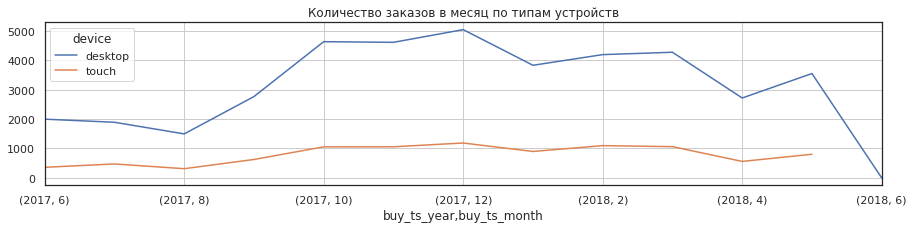

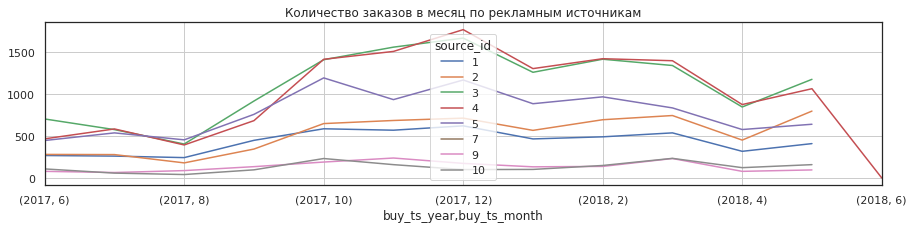

In [79]:
#определим, сколько раз покупают за период
#найдем месяц и год даты покупки
visits_orders['buy_ts_month'] = visits_orders['buy_ts'].dt.month
visits_orders['buy_ts_year'] = visits_orders['buy_ts'].dt.year
#построим графики по количеству заказов по типам устройств и рекламным источникам
fig, ax = plt.subplots(figsize = (15,3))
pd.pivot_table(visits_orders.query('device.isin(@device)'),
               index = ['buy_ts_year', 'buy_ts_month'],
               columns = 'device',
               values = 'uid',
               aggfunc = 'count').plot(grid=True, ax = ax, title='Количество заказов в месяц по типам устройств')
plt.show()
fig, ax = plt.subplots(figsize = (15,3))
source = ['1', '2', '3', '4', '5', '7', '9', '10']
pd.pivot_table(visits_orders.query('source_id.isin(@source)'),
               index = ['buy_ts_year', 'buy_ts_month'],
               columns = 'source_id',
               values = 'uid',
               aggfunc = 'count').plot(grid=True, ax = ax, title='Количество заказов в месяц по рекламным источникам')
plt.show()

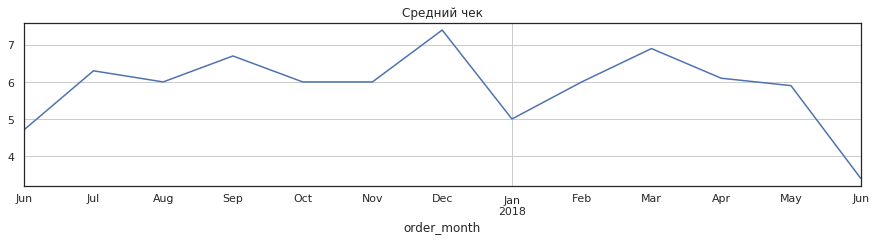

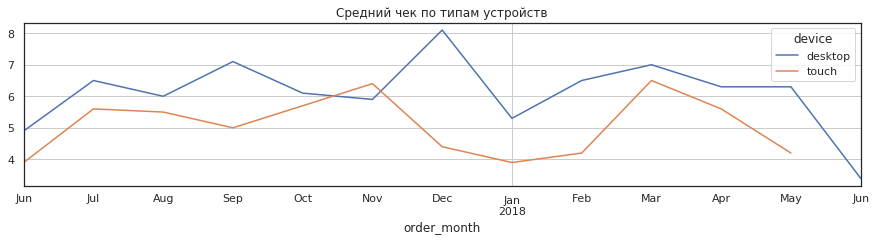

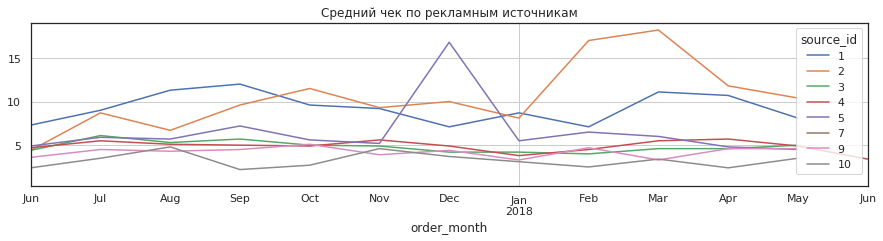

In [80]:
#посчитаем средний чек
#найдем месяц даты покупки
visits_orders['order_month'] = visits_orders['buy_ts'].astype('datetime64[M]')
#сгруппируем выручку и количество пользоателей
orders_grouped = visits_orders.pivot_table(index='order_month',aggfunc={'revenue':'sum','uid':'nunique'})
#найдем средний чек
orders_grouped['revenue_per_user'] = (orders_grouped['revenue']/orders_grouped['uid']).round(1)
orders_grouped['revenue_per_user'].plot(grid=True, title='Средний чек', figsize = (15,3))
plt.show()

#найдем средний чек по типам устройств
orders_grouped_device = visits_orders.groupby(['device', 'order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_device['revenue_per_user'] = (orders_grouped_device['revenue']/orders_grouped_device['uid']).round(1)

fig, ax = plt.subplots(figsize = (15,3))
pd.pivot_table(orders_grouped_device.query('device.isin(@device)'),
               index = 'order_month',
               columns = 'device',
               values = 'revenue_per_user').plot(grid=True, ax = ax, title='Средний чек по типам устройств')
plt.show()
#найдем средний чек по рекламным источникам
orders_grouped_source = visits_orders.groupby(['source_id', 'order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_source['revenue_per_user'] = (orders_grouped_source['revenue']/orders_grouped_source['uid']).round(1)

fig, ax = plt.subplots(figsize = (15,3))
pd.pivot_table(orders_grouped_source.query('source_id.isin(@source)'),
               index = 'order_month',
               columns = 'source_id',
               values = 'revenue_per_user').plot(grid=True, ax = ax, title='Средний чек по рекламным источникам')
plt.show()

In [81]:
#найдем, сколько денег потратили (всего / на каждый источник / по времени)
#найдем, сколько потратили денег всего за период
costs_all = costs['costs'].sum()
print('Всего за период потратили на маркетинг:',costs_all)

Всего за период потратили на маркетинг: 329131.62


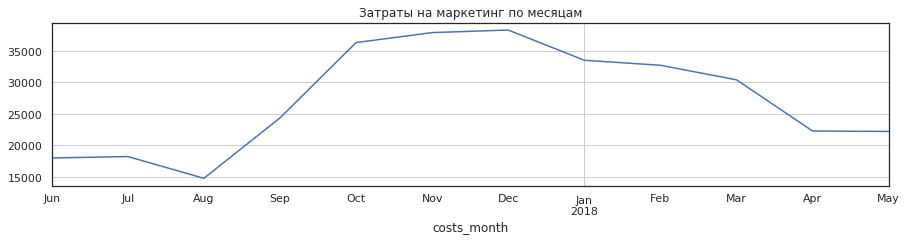

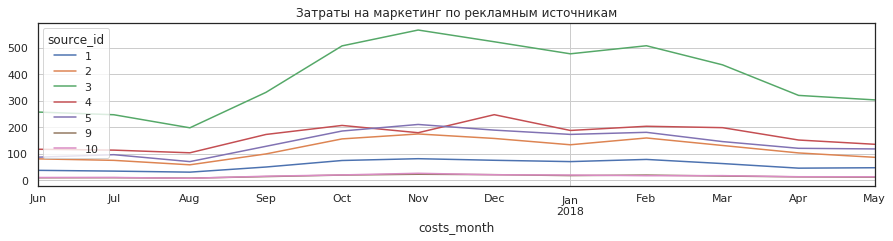

In [82]:
#найдем, сколько потратили денег по времени
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs_time = costs.groupby(['costs_month']).agg({'costs':'sum'})
costs_time['costs'].plot(grid=True, figsize = (15,3), title='Затраты на маркетинг по месяцам')
plt.show()

#найдем затраты на маркетинг по источникам
fig, ax = plt.subplots(figsize = (15,3))
pd.pivot_table(costs.query('source_id.isin(@source)'),
               index = 'costs_month',
               columns = 'source_id',
               values = 'costs').plot(grid=True, ax = ax, title='Затраты на маркетинг по рекламным источникам')

In [83]:
#найдем LTV (итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок)
#найдем месяц первой покупки
first_order_date = visits_orders.groupby(['uid']).agg({'buy_ts':'min'}).rename(columns = {'buy_ts':'buy_ts_min'})
visits_orders_new = visits_orders.set_index('uid').join(first_order_date).reset_index()
visits_orders_new['first_order_month'] = visits_orders_new['buy_ts_min'].astype('datetime64[M]')
#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = visits_orders_new.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts_revenue = visits_orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#добавим в таблицу данные о том, сколько людей первый раз совершили покупку в каждый месяц
report = pd.merge(cohort_sizes, cohorts_revenue, on='first_order_month')
#найдем валовую прибыль, умножив выручку на маржинальность, маржинальность примем за единицу 
#построим «возрастные» когорты, где в столбцах — не месяц заказа, а возраст (age) когорты.
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
#найдём LTV, разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте
#визуализируем когорты в виде сводной таблицы
report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
#найдем LTV накопительным итогом
output = output.cumsum(axis=1)
output = output.fillna('')

output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,


In [84]:
#найдем CAC (стоимость привлечения клиента; сумма денег, которая показывает, во сколько обходится новый клиент компании) для каждого источника?
#добавим данные о расходах в отчёт и посчитаем CAC
report_new = pd.merge(report, costs_time, left_on='first_order_month', right_on='costs_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
#print(report_new.head())
#посчитаем romi (на сколько окупились расходы)
#разделим ltv на cac
report_new['romi'] = report_new['ltv'] / report_new['cac']
output_romi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi',
        aggfunc='mean')
output_romi.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.530530,0.58503,0.634174,0.741379,0.856205,0.938798,1.04553,1.11084,1.17296,1.24099,1.30514,1.33398
2017-07-01,0.633623,0.668962,0.734697,0.772542,0.79118,0.807631,0.820304,0.835255,0.852253,0.867766,0.884178,
2017-08-01,0.488747,0.532466,0.574934,0.611176,0.656939,0.683202,0.702715,0.74023,0.767297,0.784708,,
2017-09-01,0.597833,0.7162,0.771374,1.19246,1.23489,1.30342,1.37773,1.40349,1.42297,,,
2017-10-01,0.597866,0.661881,0.684749,0.703525,0.721634,0.736016,0.74615,0.759947,,,,
2017-11-01,0.554931,0.597911,0.619394,0.654377,0.670312,0.676112,0.688485,,,,,
2017-12-01,0.542015,0.5718,0.677624,0.799484,0.835281,0.873951,,,,,,
2018-01-01,0.416173,0.445835,0.476455,0.490823,0.497132,,,,,,,
2018-02-01,0.463807,0.494855,0.503615,0.511887,,,,,,,,


In [85]:
#найдем среднюю когорту
#узнаем, как быстро в среднем когорты окупаются
#усредним значения каждой колонки и «сложим» таблицу в единую строку методом
output_romi.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

In [101]:
#найдем LTV по рекламным источникам
#посчитаем количество новых покупателей за каждый месяц по источнику
cohort_sizes_source = visits_orders_new.groupby(['first_order_month','source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes_source.columns = ['first_order_month', 'source_id', 'n_buyers']
#посчитаем выручку за каждый месяц по источнику
cohorts_revenue_source = visits_orders_new.groupby(['first_order_month', 'order_month', 'source_id']).agg({'revenue': 'sum'}).reset_index()
#добавим в таблицу данные о том, сколько людей первый раз совершили покупку
report_source = pd.merge(cohort_sizes_source, cohorts_revenue_source, on=['first_order_month','source_id'])
#построим «возрастные» когорты, где в столбцах возраст (age) когорты.
margin_rate = 1
report_source['gp'] = report_source['revenue'] * margin_rate
report_source['age'] = (report_source['order_month'] - report_source['first_order_month']) / np.timedelta64(1, 'M')
report_source['age'] = report_source['age'].round().astype('int')
#найдём LTV, разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте
#визуализируем когорты в виде сводной таблицы
report_source['ltv'] = report_source['gp'] / report_source['n_buyers']
output_source = report_source.pivot_table(
        index='source_id', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
#найдем LTV накопительным итогом
output_source = output_source.cumsum(axis=1)
output_source = output_source.fillna('')

output_source

age,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.314485,7.36159,8.52454,9.63855,10.4546,11.0289,11.7052,12.9958,14.4745,15.6175,16.6838,18.3545
2,6.501886,8.15608,9.81661,11.6327,12.6659,13.4892,14.42,15.0236,15.5315,15.8806,16.7417,17.175
3,4.605593,4.92608,5.1095,5.25917,5.37508,5.46374,5.53169,5.61209,5.69541,5.747,5.78886,5.82104
4,4.571089,4.76648,4.89118,5.0989,5.32186,5.63879,6.16841,6.32799,6.43993,6.76887,7.41429,7.49918
5,4.834917,5.14658,5.43434,7.45413,7.81791,8.26993,8.57818,8.83218,9.05995,9.47227,9.58769,9.70433
7,1.220000,,,,,,,,,,,
9,4.008411,4.32279,4.6846,5.0388,5.26046,5.46327,5.73122,5.96275,6.45233,6.55124,6.62871,
10,3.267817,3.34744,3.42526,3.5611,3.61821,3.65721,3.69458,3.75647,3.77017,3.86098,,


In [102]:
#найдем CAC (стоимость привлечения клиента; сумма денег, которая показывает, во сколько обходится новый клиент компании) для каждого источника?
#добавим данные о расходах в отчёт и посчитаем CAC
costs_month = costs.groupby(['costs_month','source_id']).agg({'costs': 'sum'}).reset_index()
report_source_new = pd.merge(report_source, costs_month, left_on=['first_order_month','source_id'], right_on=['costs_month','source_id'])
report_source_new['cac'] = report_source_new['costs'] / report_source_new['n_buyers']

In [103]:
#посчитаем romi (на сколько окупились расходы)
#разделим ltv на cac
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']
output_source_romi = report_source_new.pivot_table(
        index='source_id', 
        columns='age', 
        values='romi',
        aggfunc='mean')
output_source_romi.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.892768,1.045519,1.217648,1.381623,1.509242,1.597393,1.702992,1.889201,2.104519,2.277989,2.44887,2.73087
2,0.549286,0.675443,0.803552,0.948151,1.031692,1.098030,1.173815,1.225571,1.271148,1.303542,1.38552,1.42746
3,0.336151,0.358647,0.371872,0.382765,0.391258,0.397960,0.402996,0.408503,0.414377,0.417857,0.420872,0.423528
4,0.757409,0.790097,0.808596,0.839608,0.869708,0.908944,0.975350,0.994524,1.007967,1.046696,1.12285,1.13283
5,0.664923,0.709609,0.751587,1.060376,1.116196,1.185789,1.232191,1.270911,1.305314,1.367131,1.38386,1.40098
9,0.774013,0.833264,0.909433,0.983468,1.029064,1.072658,1.130357,1.181169,1.284255,1.307649,1.32365,
10,0.727377,0.745399,0.759264,0.782877,0.794532,0.800815,0.808561,0.821517,0.824341,0.838788,,


### Шаг 4. Общий вывод

В результате проведенного анализа можно сделать следующие выводы:
1. Среднее количество пользователей в день, неделю, месяц равно соответственно 907, 5716, 23228 человек. При этом 16% пользователей за неделю и 4% пользователей за месяц ежедневно посещают сайт.
2. Среднее количество пользователей стационарных компьютеров больше в среднем в 2,5 раза, чем пользователей мобильных устройств. Пик пользователей приходится на вторую половину ноября 2017, спад приходится под конец сезона – в апреле 2018.
3. В среднем на одного пользователя приходится не более одной сессии в день. Средняя продолжительность сессии равна одной минуте.
4. Коэффициент удержания в первую неделю убывает по когортам. Для первой когорты показатель равен 7,9%, а для последней – 4,8%; за 10 месяцев коэффициент удержания упал на 3,1%. В среднем по всем когортам с течением времени происходит снижение коэффициента удержания, однако те, кто совершил первый заказ в июне 2017 показывают рост показателя вплоть до 5-го месяца «жизни».
5. Среднее время от начала первой сессии до покупки равно 64 минутам. Пользователи стационарных компьютеров покупают в среднем быстрее более чем в два раза. Пользователи, которые были привлечены с помощью рекламного источника №10 покупают в среднем за 18 минут, по источникам №3-7 – от 32 до 52 минут в среднем.
6. Количество заказов с мобильных устройств за весь период не превышает 1,1 тыс. заказов, в то время, как количество заказов со стационарных компьютеров колеблется от 1,5 до 5 тыс. Наибольшее количество заказов совершают пользователи, которые были привлечены с помощью 3, 4 и 5-го источников.
7. Наибольший средний чек в декабре, в разгар сезона. Средний чек пользователей стационарных компьютеров от 5 до 8 единиц, а мобильных не более 6,5 единиц. Наибольший средний чек за данный период по клиентам, которые были привлечены с помощью 1, 2 и 5-го рекламных источников.
8. Всего затраты на маркетинг за период составили 329 тыс. Пик затрат приходился на октябрь-декабрь 2017 г. Больше всего потратили на рекламный источник №3 и меньше всего на источник №10. Из источников с самым большим количеством заказов и средним чеком меньше всего было потрачено на источник №1.
9. Наибольшую сумму денег в среднем со всех своих покупок приносят клиенты 1 и 4 когорты, которые совершили покупки в июне и сентябре 2017. Маркетинговые затраты полностью окупаются по 1 и 4 когорте. В среднем по всем когортам маркетинговые расходы окупаются с 8-10 месяца "жизни" когорты
10. Наибольшую сумму денег приносят пользователи, которые были привлечены с помощью рекламного источника №1. Маркетологам необходимо сделать акцент именно на этом источнике, так как он полностью окупается, пользователи показывают наибольший средний чек